# Mouse gliogenesis

## Imports

In [1]:
import anndata as ad
import numpy as np
import optax
import scanpy as sc

import stories

In [2]:
import jax

jax.devices()

[cuda(id=0)]

## Load the data

In [3]:
# Load the data
adata = ad.read_h5ad("../data/dorsal_midbrain/dorsal_midbrain_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 4581 × 10000
    obs: 'CellID', 'Batch', 'annotation', 'S_score', 'G2M_score', 'phase', 'Time point', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'proliferation', 'apoptosis', 'growth'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'FP200000600TR_E3', 'SS200000108BR_A3A4', 'SS200000108BR_B1B2', 'SS200000131BL_C3C4', 'SS200000131BL_C5C6', 'angle_dict', 'annotation_colors', 'hvg', 'neighbors', 'pca'
    obsm: 'X_isomap', 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connec

## Preprocess the data

In [4]:
# Some shorthands
space_key = "spatial"
omics_key = "X_pca_harmony"
time_key = "time"
weight_key = "growth"

In [5]:
# Select a given number of principal components then normalize the embedding.
adata.obsm[omics_key] = adata.obsm[omics_key][:, :20]
adata.obsm[omics_key] /= adata.obsm[omics_key].max()
print("Normalized embedding.")

Normalized embedding.


In [6]:
# Center and scale each timepoint in space.
timepoints = np.sort(np.unique(adata.obs["time"]))
adata.obsm[space_key] = adata.obsm[space_key].astype(float)
for t in timepoints:
    idx = adata.obs[time_key] == t

    mu = np.mean(adata.obsm[space_key][idx, :], axis=0)
    adata.obsm[space_key][idx, :] -= mu

    std = np.std(adata.obsm[space_key][idx, :], axis=0)
    adata.obsm[space_key][idx, :] /= std
print("Centered and scaled space.")

Centered and scaled space.


## Train the model

In [7]:
# Initialize the model.
model = stories.SpaceTime(quadratic_weight=1e-3)

In [8]:
scheduler = optax.cosine_decay_schedule(1e-2, 10_000)
model.fit(
    adata=adata,
    time_key=time_key,
    omics_key=omics_key,
    space_key=space_key,
    weight_key=weight_key,
    optimizer=optax.adamw(scheduler),
    key=jax.random.PRNGKey(20_181),
)

 13%|█▎        | 1331/10000 [04:51<31:38,  4.57it/s, iteration=1332, train_loss=0.022217069, val_loss=0.089612335]


Met early stopping criteria, breaking...


## Display the potential

In [9]:
palette = {"GlioB": "#008941ff", "NeuB": "#ff34ffff", "RGC": "#00bfffff"}

In [10]:
stories.tools.compute_potential(adata, model, "X_pca_harmony")

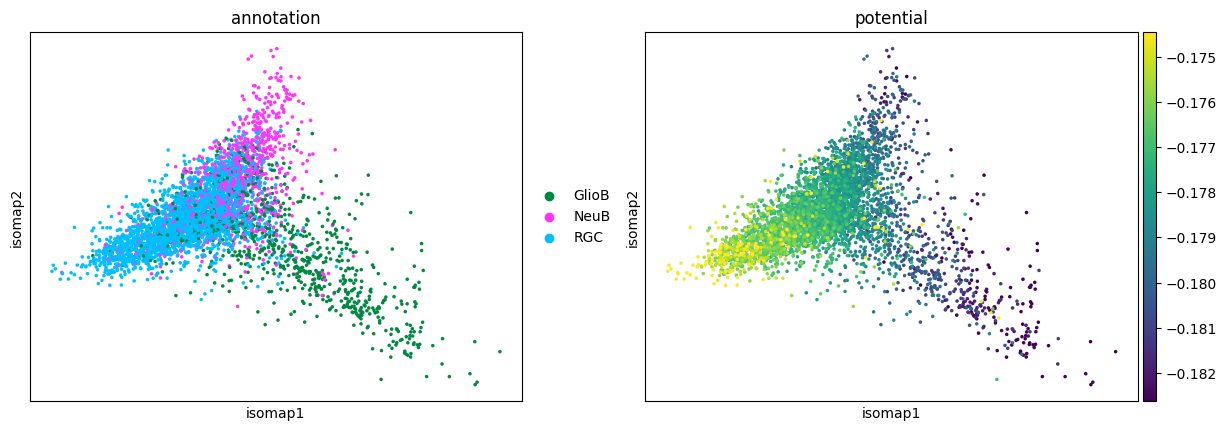

In [11]:
sc.pl.embedding(
    adata, basis="isomap", color=["annotation", "potential"], vmax="p98", vmin="p02"
)

## Display the velocity

In [12]:
stories.tools.compute_velocity(adata, model, "X_pca_harmony")

100%|██████████| 4581/4581 [00:03<00:00, 1281.51cell/s]


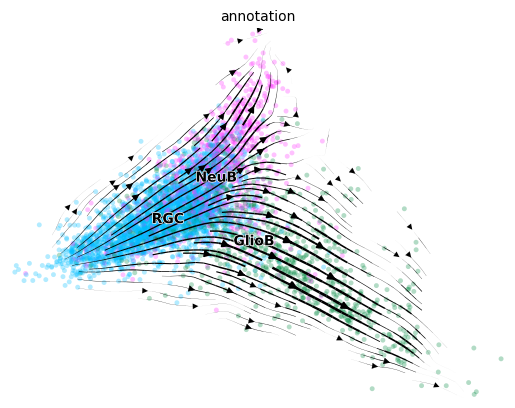

In [13]:
stories.tools.plot_velocity(
    adata, "X_pca_harmony", basis="isomap", color="annotation", palette=palette, s=50
)